## Prepare observations: convolution, clip

We want to downgrade all the observations to the lowest resolution (300 km/s) and clip the wavelength range to [4023,6000] A

Load the modules and define the format of the plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import os
import torch
from torch import nn
from torch import optim
from accelerate import Accelerator #to use pytorch
from torch.utils.data import DataLoader
from encoder import SpectrumEncoder,MLP,encoder_percentiles,load_model
from tqdm import tqdm,trange
from sbi import utils as Ut
from sbi import inference as Inference

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)
mpl.rcParams["mathtext.fontset"]='dejavuserif'

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the observational data from individual files

In [2]:
files= sorted(os.listdir('obs'))[1:]
waves=[]
fluxes=[]
sigma_gal=[]
for f in files:
    data=np.loadtxt('./obs/'+f)
    waves.append(data[:,0])
    fluxes.append(data[:,1])
    arr=np.array([float(f[6:12]),float(f[13:19])])
    sigma_gal.append(np.mean(arr))

Inspect the data

In [ ]:
n=len(fluxes)

for i in range(n):
    plt.plot(waves[i],fluxes[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.legend(fontsize=10)
plt.show()


"""for i in range(n):
    print(np.min(waves[i]),np.max(waves[i]))"""

#largest wavelength range from 4000 to 7400 but we will limit ourselves to the range from 4000 to 5500"

for i in range(n):
    plt.plot(waves[i],fluxes[i],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s')
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.xlim(4000,5500)
plt.legend(fontsize=10)
plt.show()


Limit wavelength range

In [ ]:
fluxes_short=[]
waves_short=[]

for i in range(n):
    ind=np.where((waves[i]>3999)&(waves[i]<7401))[0]
    fluxes_short.append(fluxes[i][ind])
    waves_short.append(waves[i][ind])

Downgrade each spectrum to the lowest resolution (300 km/s)


$$ \sigma_{gal}^2=\sigma_{v}^2+\sigma_{ins}^2$$

We are going to convert all of them to $v=300$ km/s, so:

$$ \sigma_{diff}^2 = \sigma_{300}^2+\sigma_{ins}^2 - (\sigma_{gal}^2+\sigma_{ins}^2) = \sigma_{300}^2 - \sigma_{gal}^2   $$

And to move from velocity dispersion to kernel width, we will need unit conversions and:

$$
\mathrm{FWHM}=2 \sqrt{2 \ln 2} \sigma \approx 2.35482 \sigma
$$

In [ ]:
def gaussian_filter1d(spec, sig):
    """
    Convolve a spectrum by a Gaussian with different sigma for every pixel.
    If all sigma are the same this routine produces the same output as
    scipy.ndimage.gaussian_filter1d, except for the border treatment.
    Here the first/last p pixels are filled with zeros.
    When creating  template library for SDSS data, this implementation
    is 60x faster than a naive for loop over pixels.
    :param spec: vector with the spectrum to convolve
    :param sig: vector of sigma values (in pixels) for every pixel
    :return: spec convolved with a Gaussian with dispersion sig
    """
    sig = sig.clip(0.01)  # forces zero sigmas to have 0.01 pixels
    p = int(np.ceil(np.max(3*sig)))
    m = 2*p + 1  # kernel size
    x2 = np.linspace(-p, p, m)**2
    n = spec.size
    a = np.zeros((m, n))
    for j in range(m):   # Loop over the small size of the kernel
        a[j, p:-p] = spec[j:n-m+j+1]
    gau = np.exp(-x2[:, None]/(2*sig**2))
    gau /= np.sum(gau, 0)[None, :]  # Normalize kernel
    conv_spectrum = np.sum(a*gau, 0)
    return conv_spectrum

Apply the kernels to the observations

In [ ]:
cvel=300000 #km/s
psize=1 #delta_lambda of the observations
fluxes_conv=[]
max_sigma=np.sqrt(300**2 - np.array(sigma_gal)**2) #difference in velocity dispersion

for i in trange(n):
    #Perform unit conversion
    FWHM_gal = 2.*np.sqrt(2.*np.log(2.)) * max_sigma[i] / cvel * waves_short[i]
    FWHM_dif = np.sqrt(FWHM_gal**2)
    sigma = FWHM_dif/(psize*2.*np.sqrt(2.*np.log(2.))) # Sigma difference in pixels, for the kernel
    flux_conv = gaussian_filter1d(fluxes_short[i], sigma) 
    fluxes_conv.append(flux_conv)

#Plot two examples
for i in [0,-1]:
    plt.plot(waves_short[i][23:3378],fluxes_short[i][23:3378],label='$\\sigma$ = '+str(sigma_gal[i])+' km/s',c='k',lw=2)
    plt.plot(waves_short[i][23:3378],fluxes_conv[i][23:3378],label='$\\sigma$ = '+str(300)+' km/s',lw=3)
    
plt.ylabel('Flux')
plt.xlabel('Wavelength [$\\AA$]')
plt.title('Convolved spectra')
plt.legend(fontsize=10)
plt.show()


#Change wavelength range because of the change in resolution
waves_short_2 = []
fluxes_conv_2 = []

print('Selected wavelength range: ',waves_short[0][23],waves_short[0][2000])

for i in range(n):
    waves_short_2.append(waves_short[i][23:2001])
    fluxes_conv_2.append(fluxes_conv[i][23:2001])

Save processed spectra

In [ ]:
seds=[]
for i in range(18):
    seds.append(fluxes_conv_2[i]/np.median(fluxes_conv_2[i]))

np.save('./obs/processed/seds.npy',seds)
np.save('./obs/processed/wave.npy',waves_short_2[0])

Load processed spectra

In [3]:
#load convolved and clipped observations from stacks

seds=np.load('./obs/processed/seds.npy')

Plot processed spectra with a colormap based on the velocity dispersion

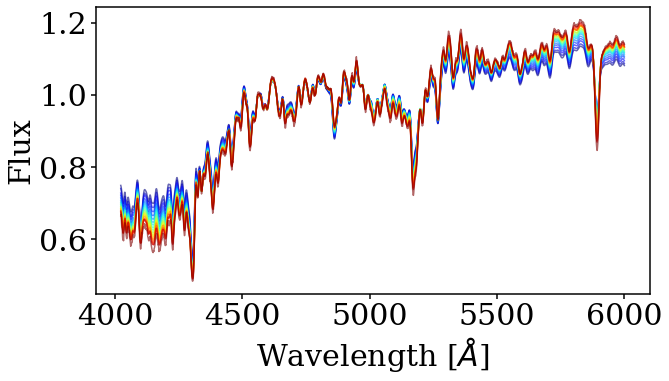

In [52]:
colors=plt.cm.jet(np.linspace(0,1,18))

plt.figure(figsize=(10,6))
colors=plt.cm.jet(np.linspace(0,1,18))
for i in range(18):
        plt.plot(range(4023,6001),seds[i],alpha=0.6,color=colors[i])
        plt.scatter(range(4023,6001),seds[i],marker='None',c=sigma_gal[i]*np.ones((len(range(4023,6001)),)),cmap='jet')
#plt.colorbar(label='$\\sigma$ [Km/s]')
#plt.clim(105,300)
plt.xlabel('Wavelength [$\\AA$]')
plt.ylabel('Flux')
#plt.legend()
plt.tight_layout()
plt.savefig('./spectra_observations.jpeg')
plt.show()

Let's start predicting SFHs and metallicity for observations

In [4]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x):

        """ generate and organize data for training and testing"""

        self.x=torch.from_numpy(x) #seds
        

    def __len__(self):
        """total number of samples"""
        return len(self.x[:,0])

    def __getitem__(self,index):
        """Generates one sample of data"""
        x=self.x[index,:]
        return x


Load encoder model trained on synthetic data and generate latent representations for the observations

In [5]:
#create a pytorch dataset

dataset = Dataset(np.array(seds) )
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file = "./saved_models/checkpoint.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=10)
model = accelerator.prepare(model)
        
#predict
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch.float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]

Getting latent vectors and predicted percentiles


100%|██████████| 18/18 [00:02<00:00,  6.67it/s]


Load Normalizing Flows model trained on synthetic data and predict posteriors for the observations sampled with 10.000 evaluations

In [45]:
file="./saved_models/my_posterior.pkl"

file = open(file, 'rb')
qphi = pickle.load(file)
file.close()

posteriors=[]


for i in trange(18):
    posteriors.append(np.array(qphi.sample((10000,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors=np.array(posteriors)

100%|██████████| 18/18 [02:33<00:00,  8.51s/it]


Save median and standard deviations of the posteriors predicted for the observations

In [6]:
np.save('post_median.npy',np.median(posteriors,axis=0))
np.save('post_stds.npy',np.std(posteriors,axis=0))

Load median and standard deviations of the posteriors predicted for the observations

In [8]:
post_median=np.load('./saved_npy/post_median.npy')
post_stds=np.load('./saved_npy/post_stds.npy')

Function to obtain redshift from cosmic time for the plots

In [9]:
import astropy.units as u
from astropy.cosmology import  Planck13,z_at_value


def z(t):
    #receives cosmic time, returns redshit
    return np.around(z_at_value(Planck13.age,t*u.Gyr).value,1)
    
def t(z):
    #receives redsfit, returns cosmic time
    return (Planck13.age(0)-Planck13.lookback_time(z)).value

Plot percentile predictions

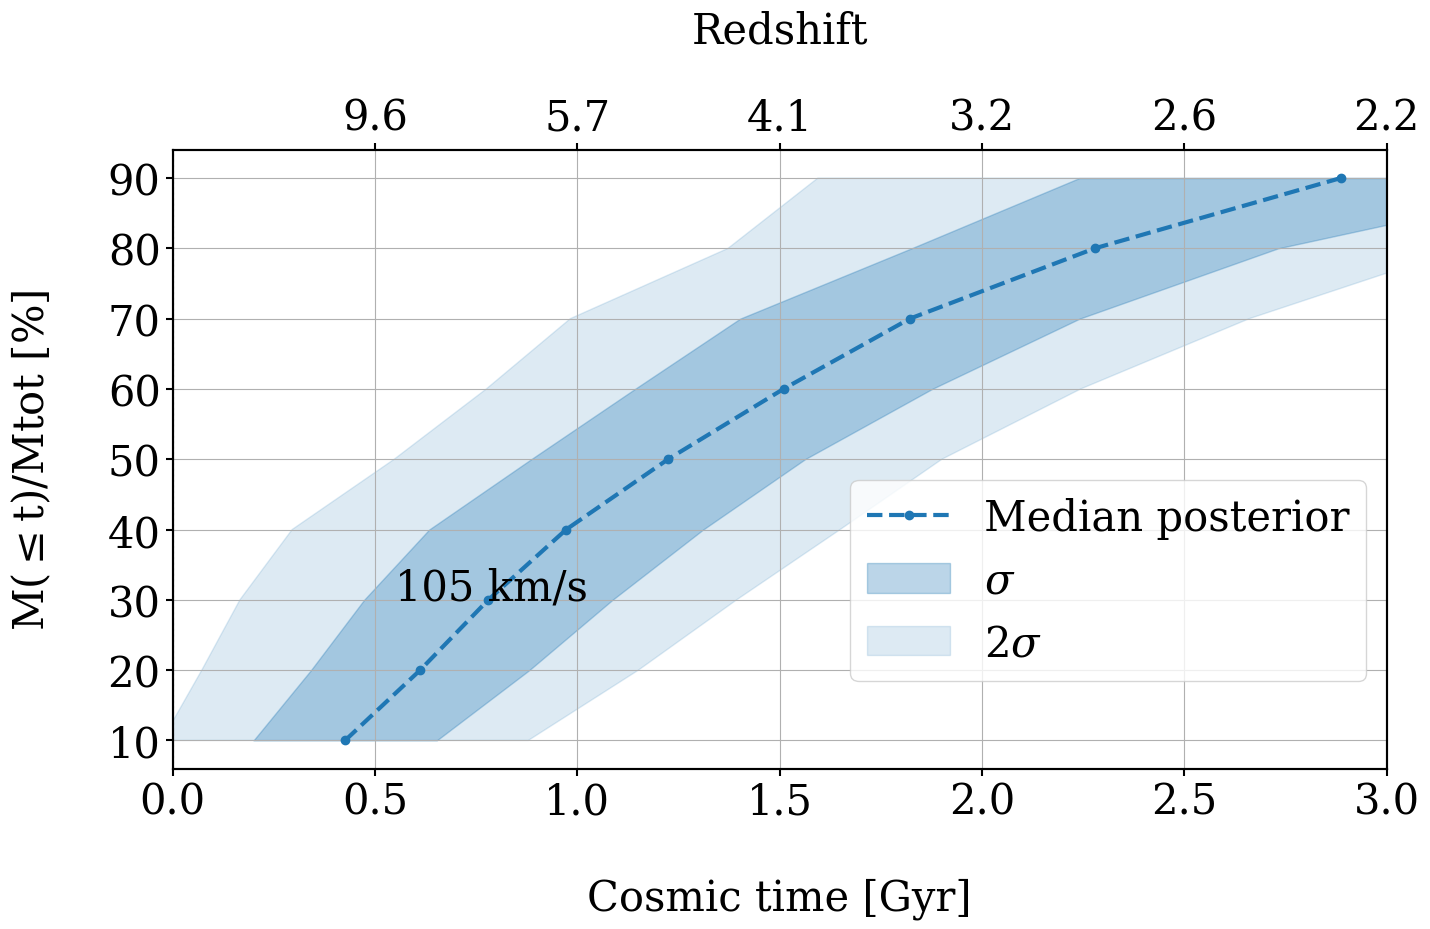

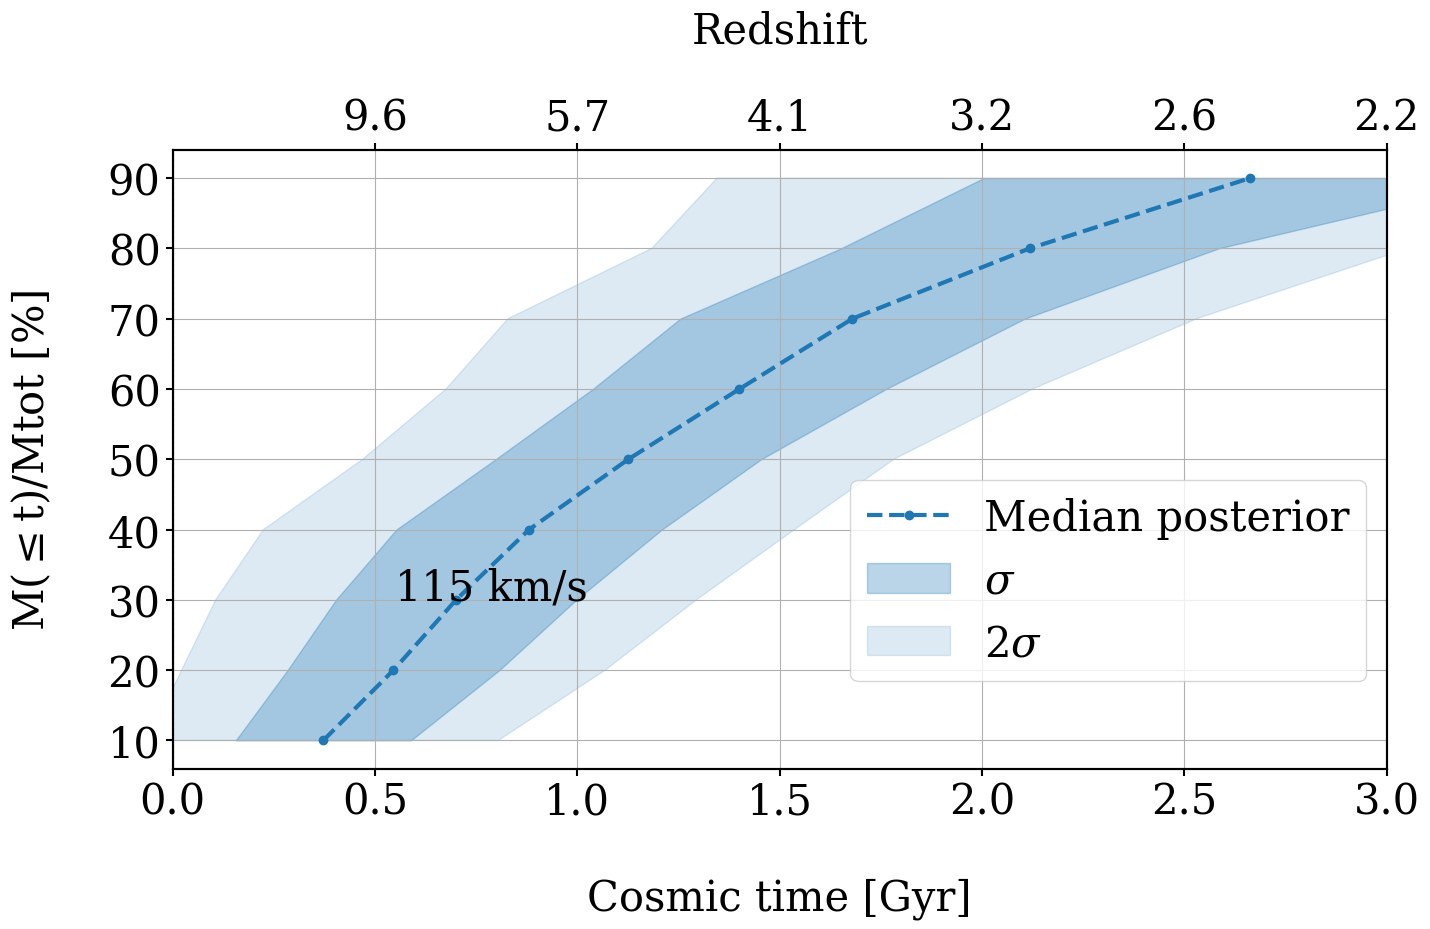

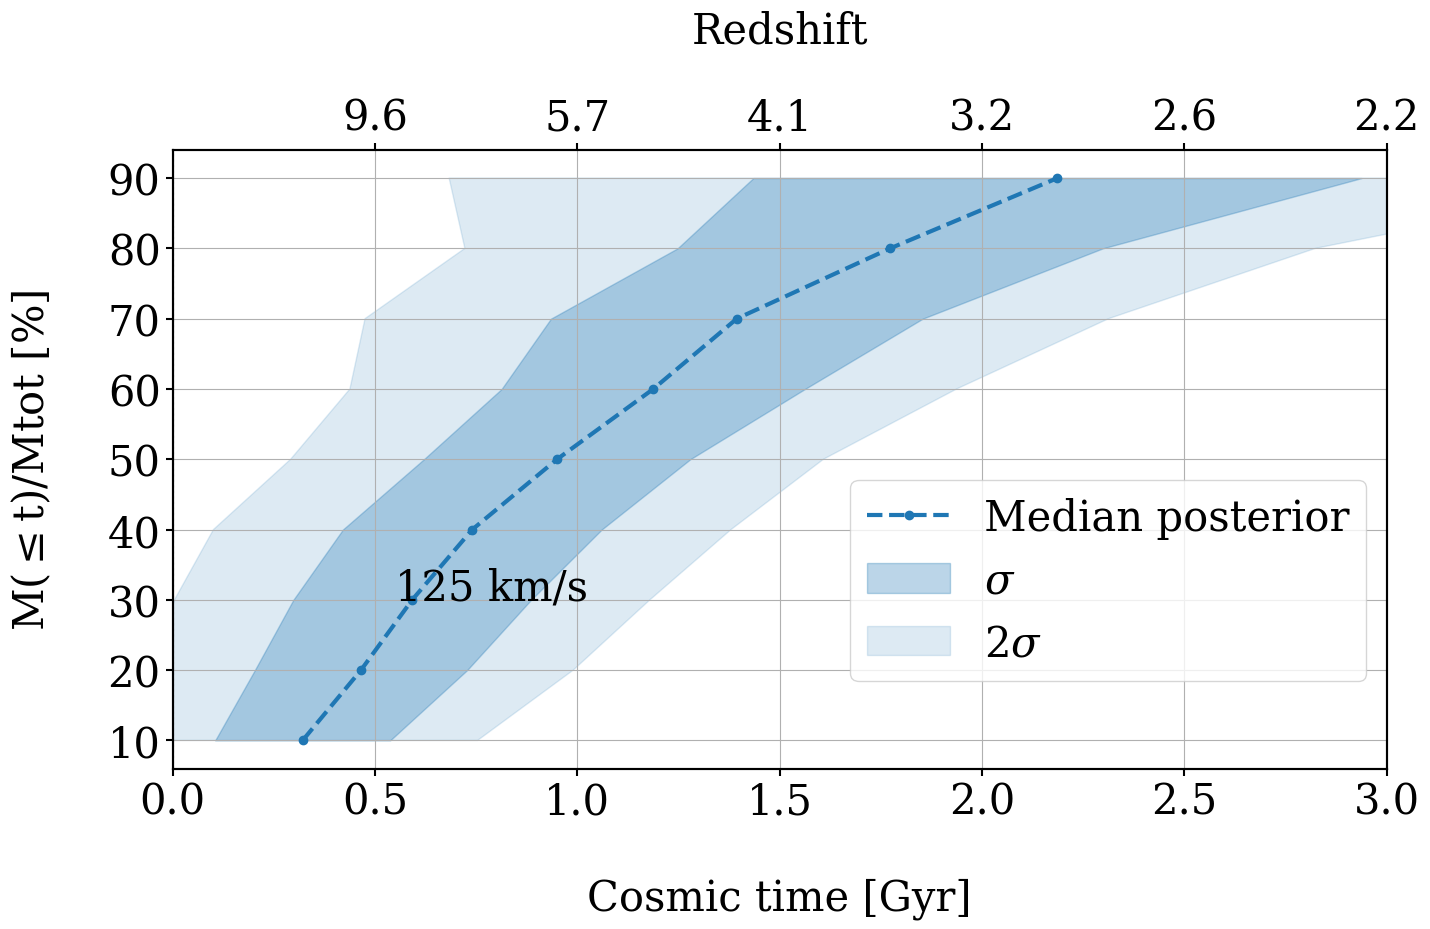

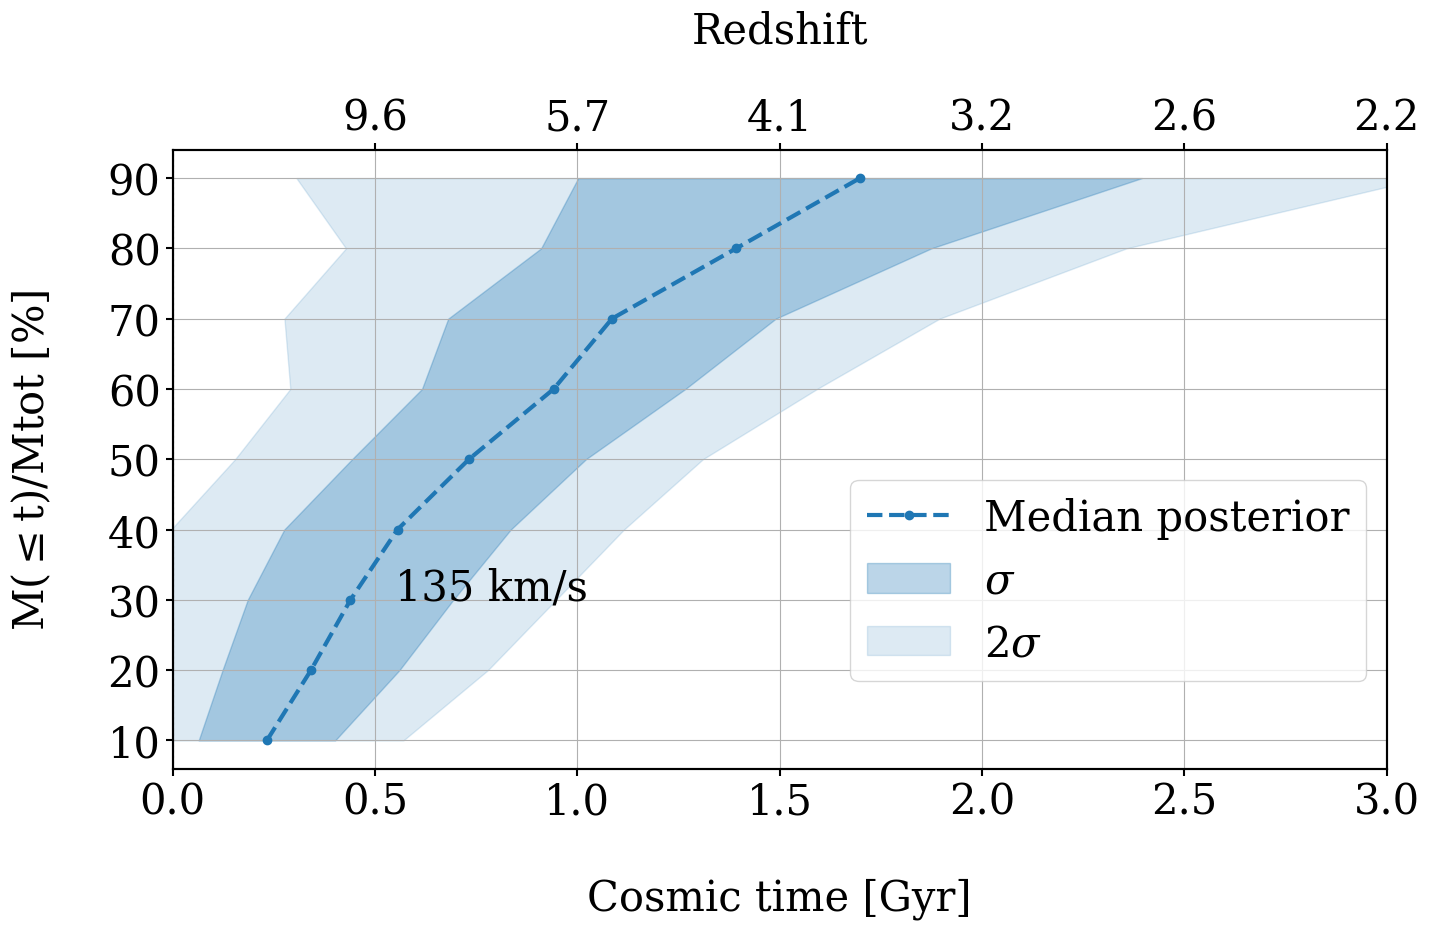

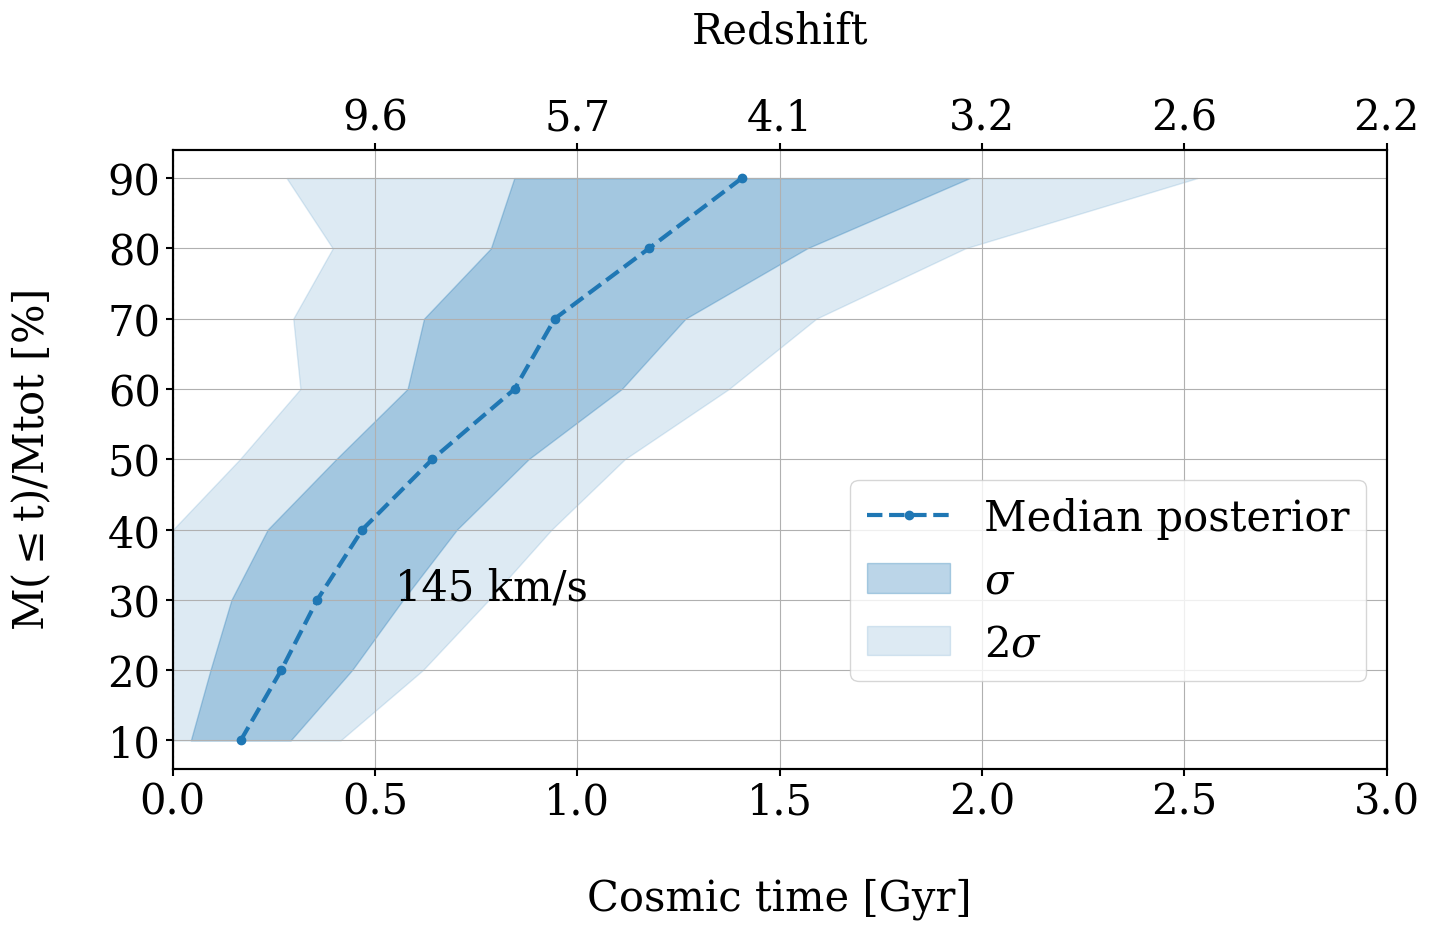

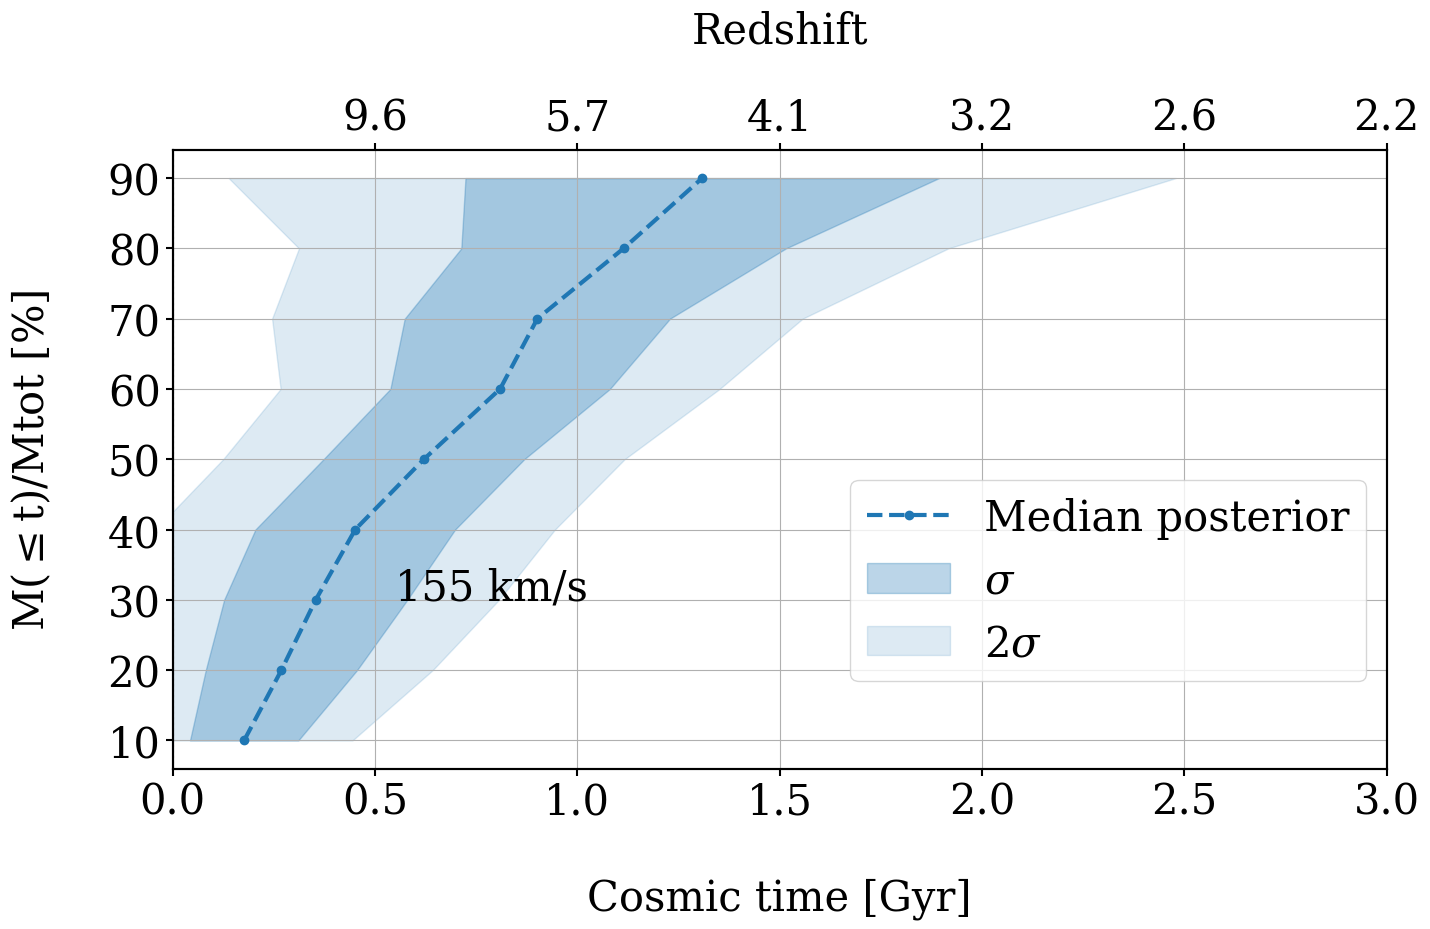

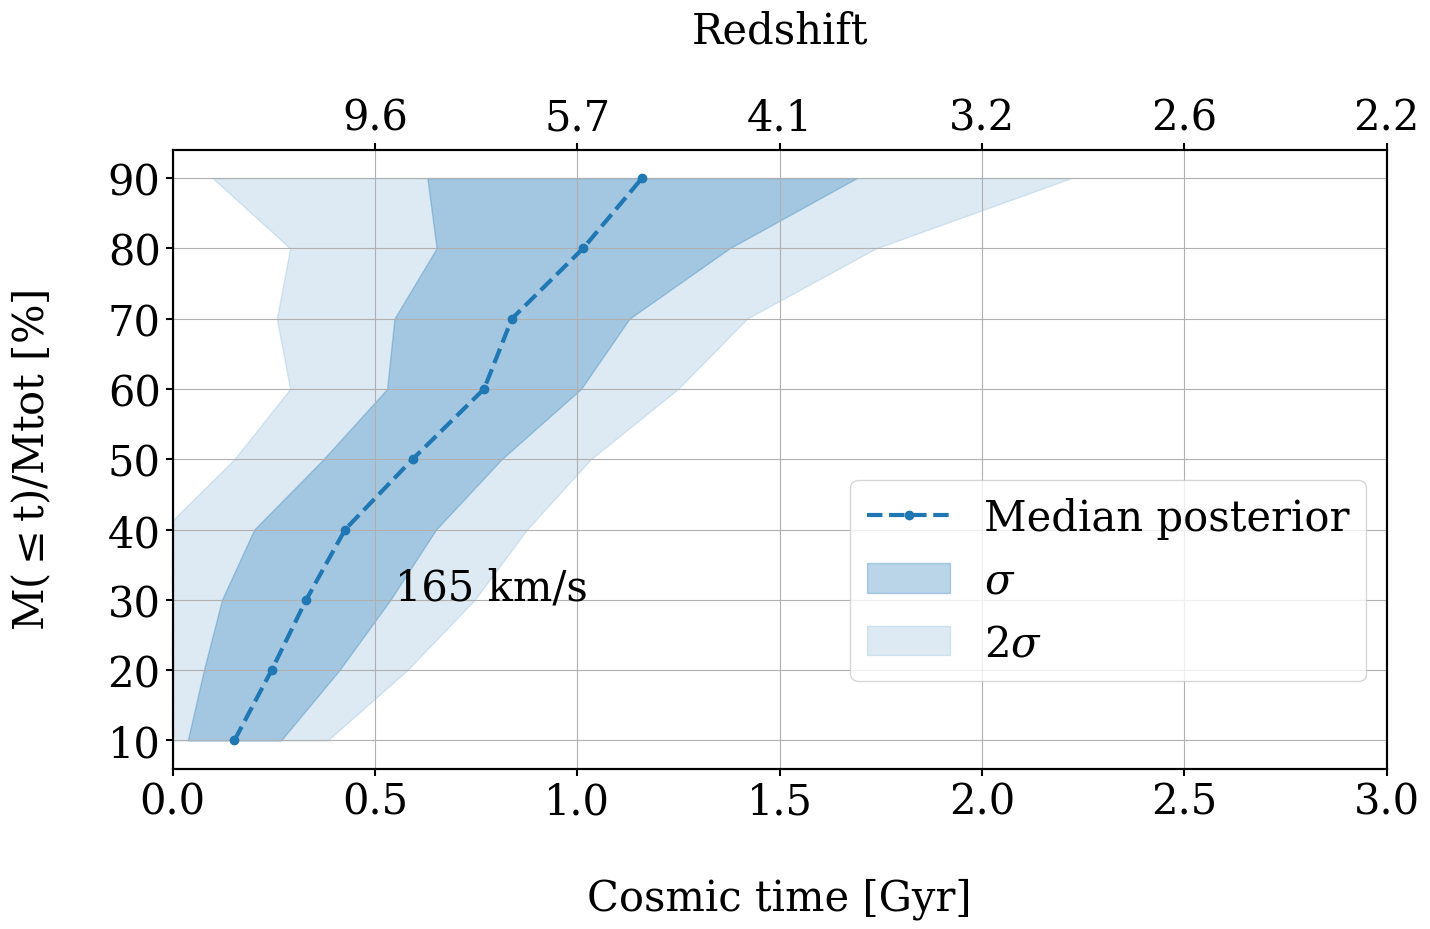

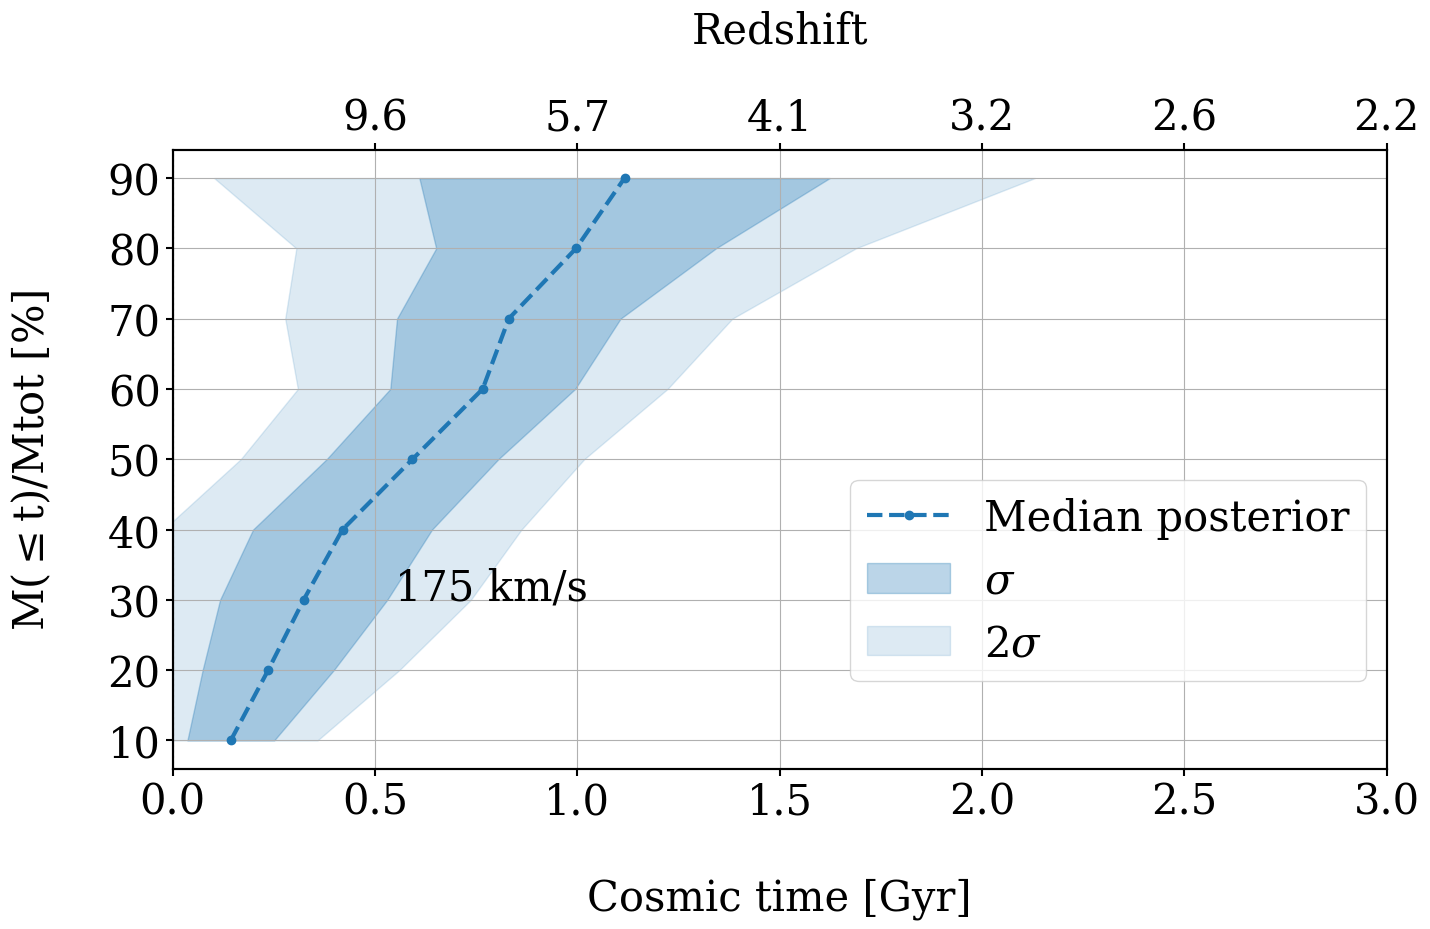

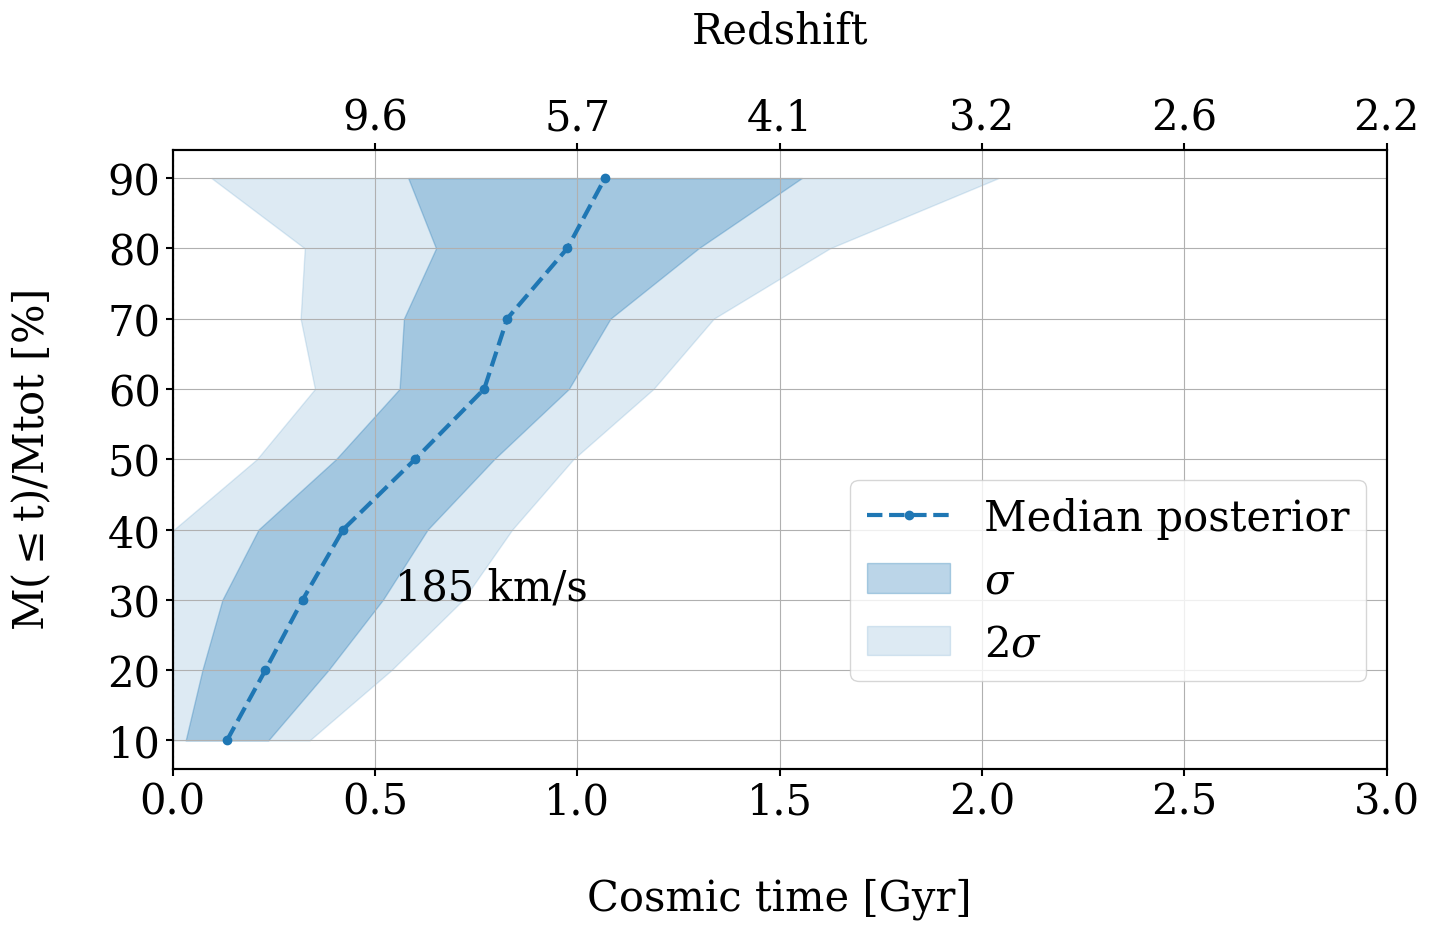

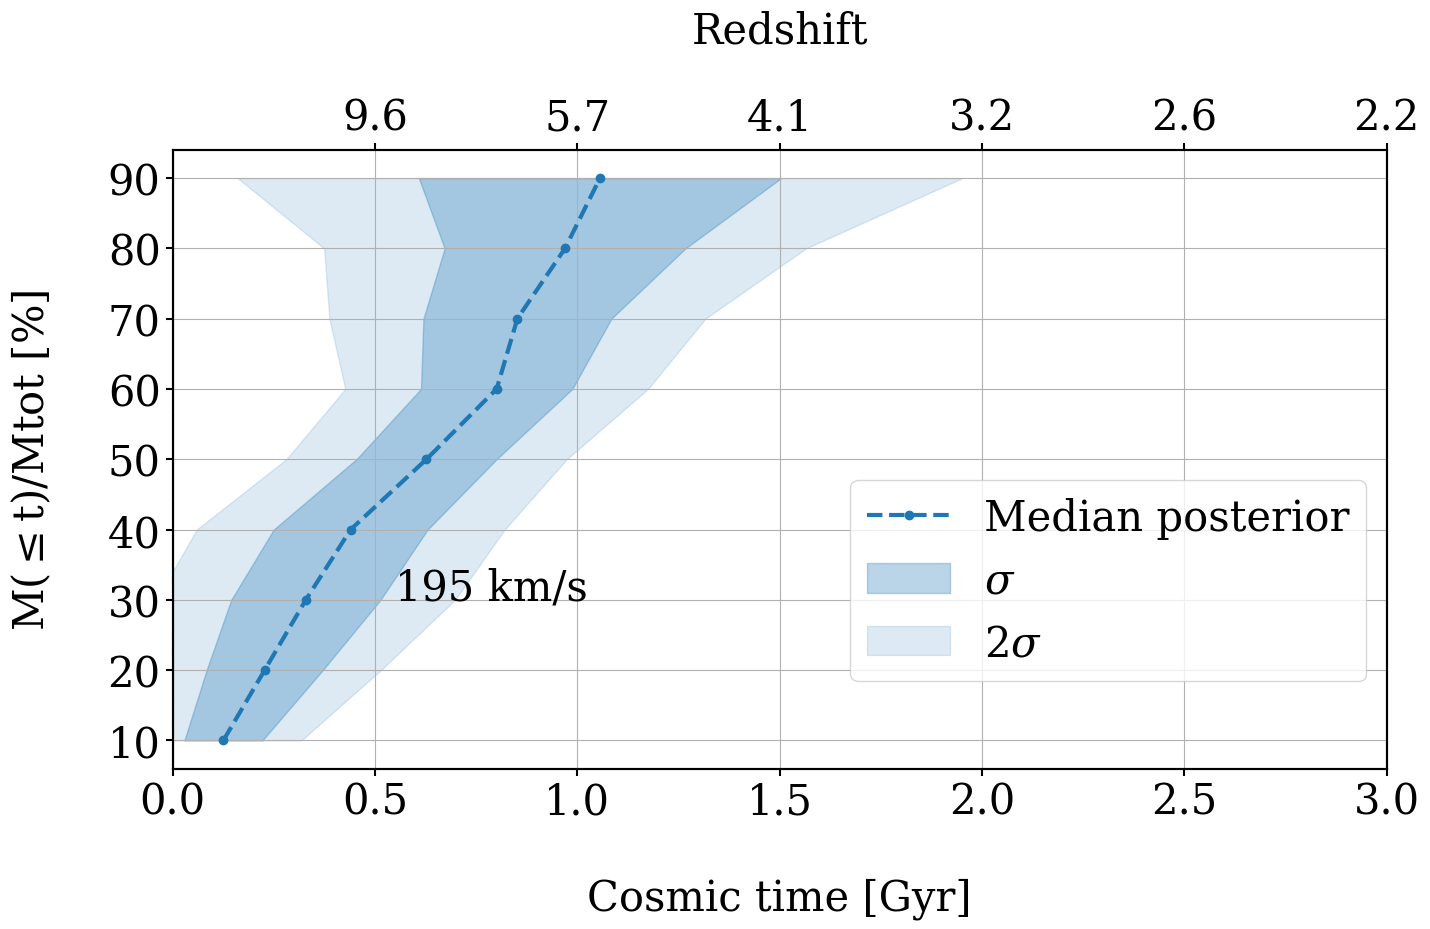

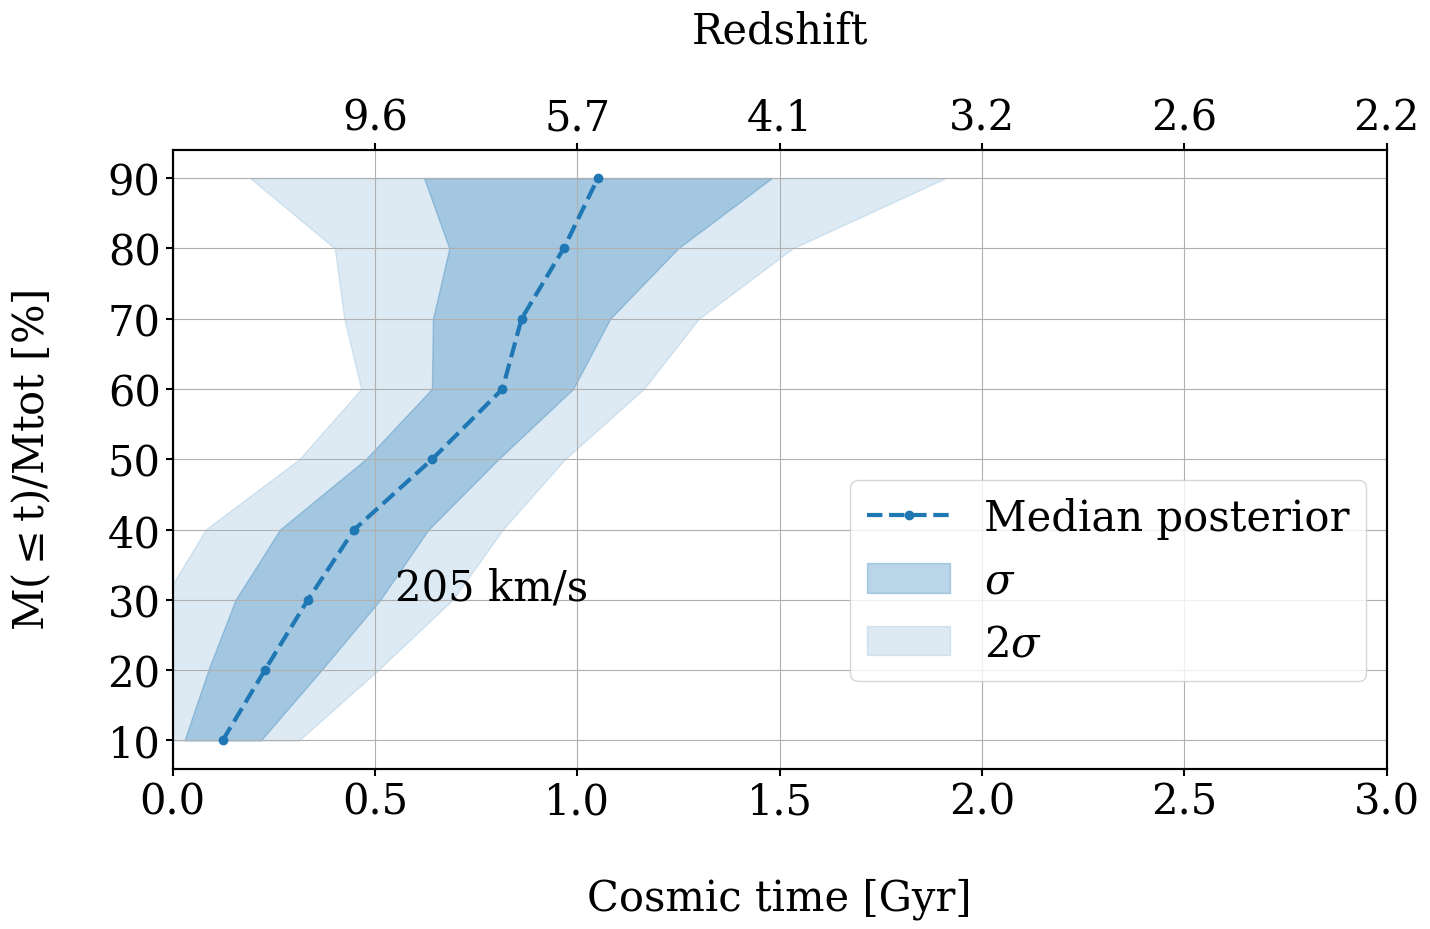

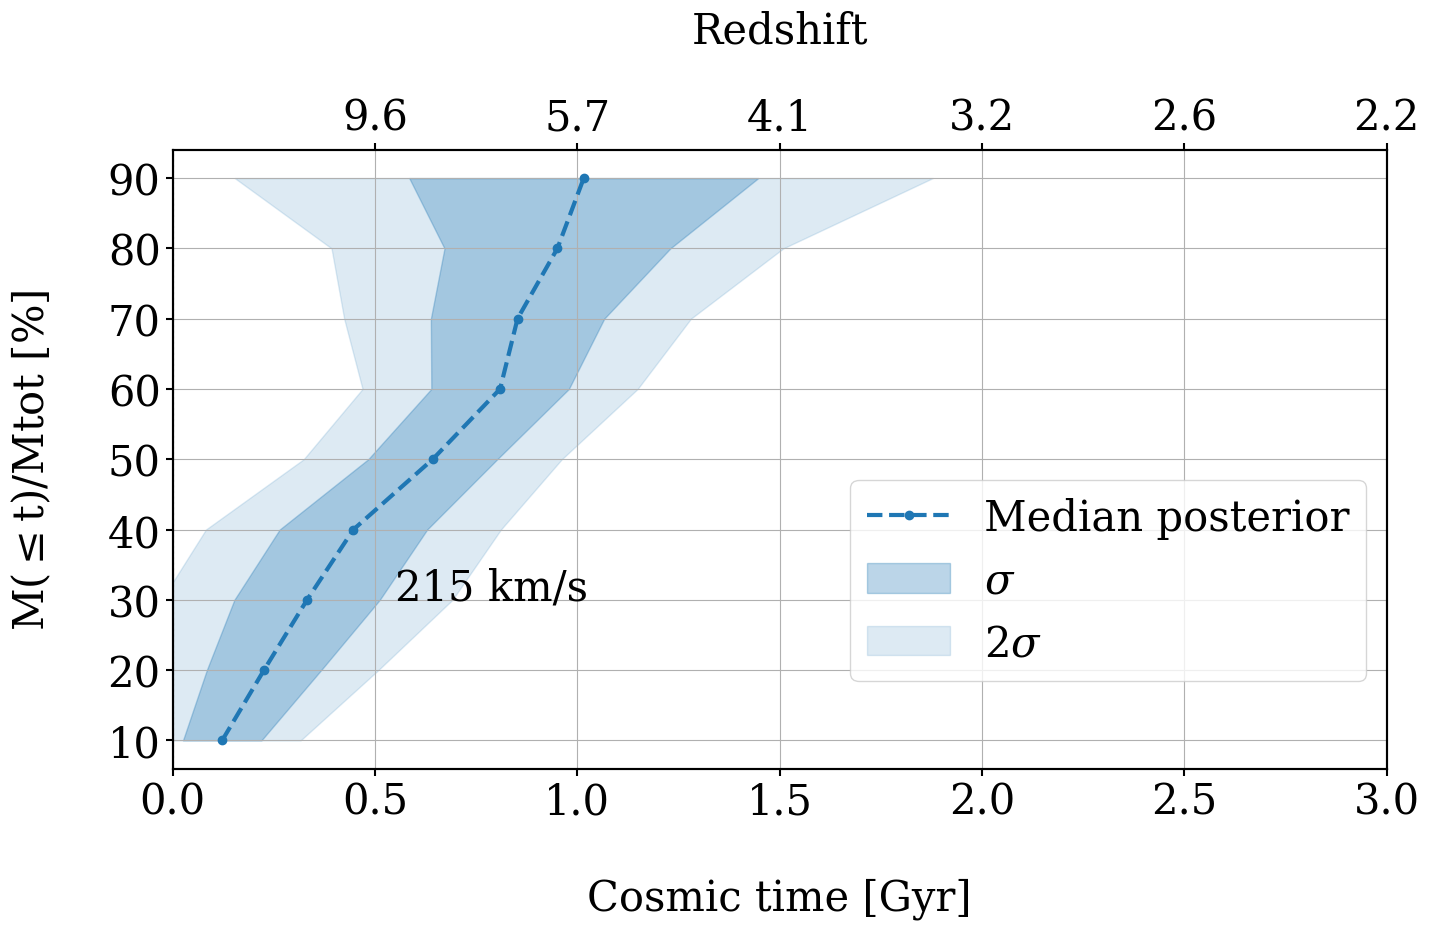

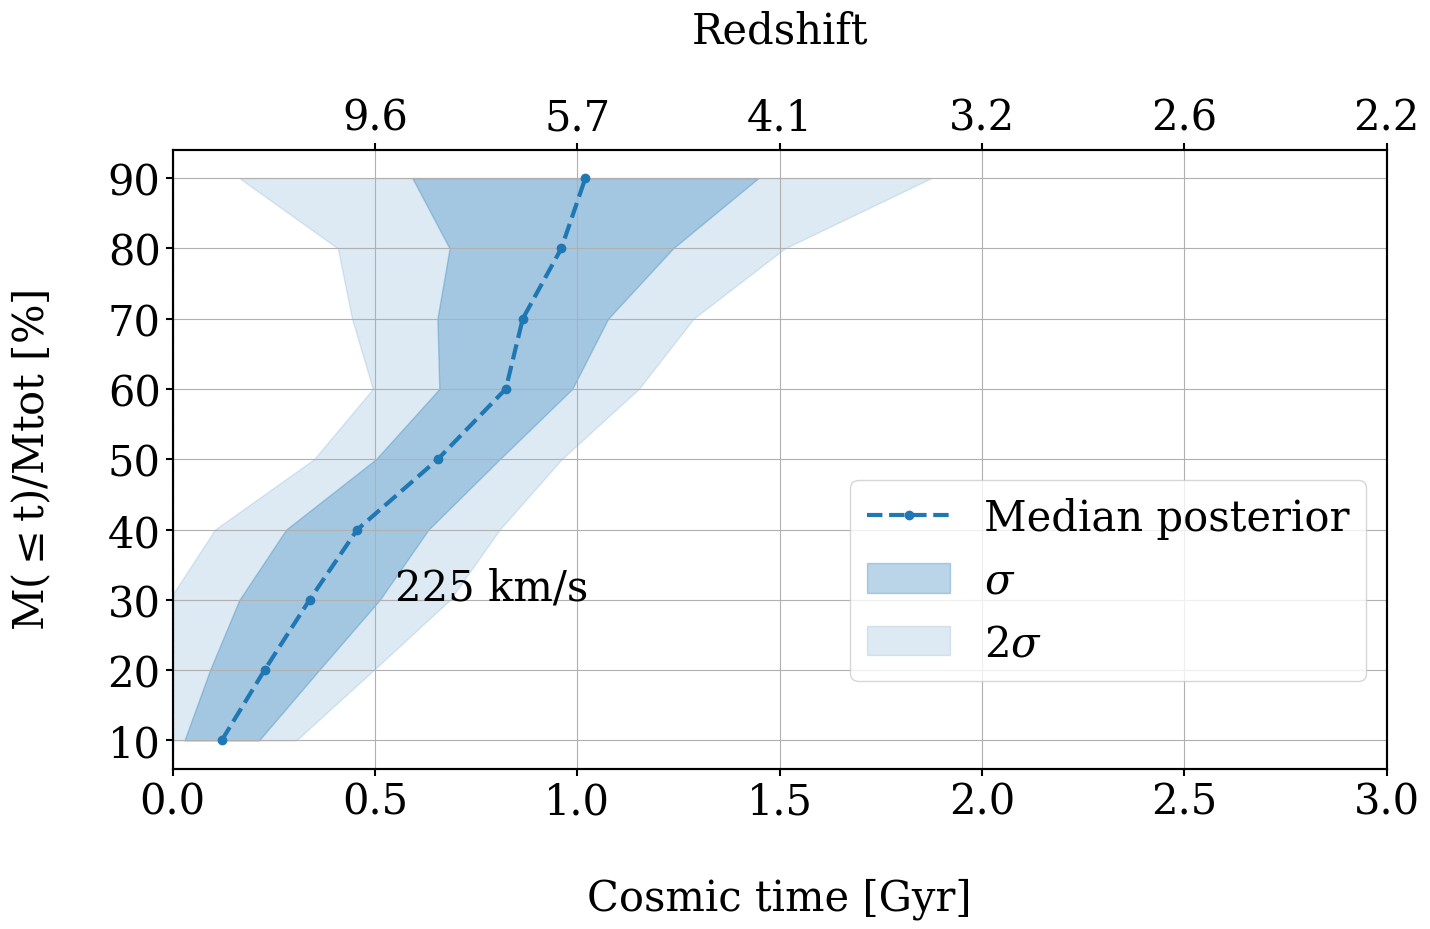

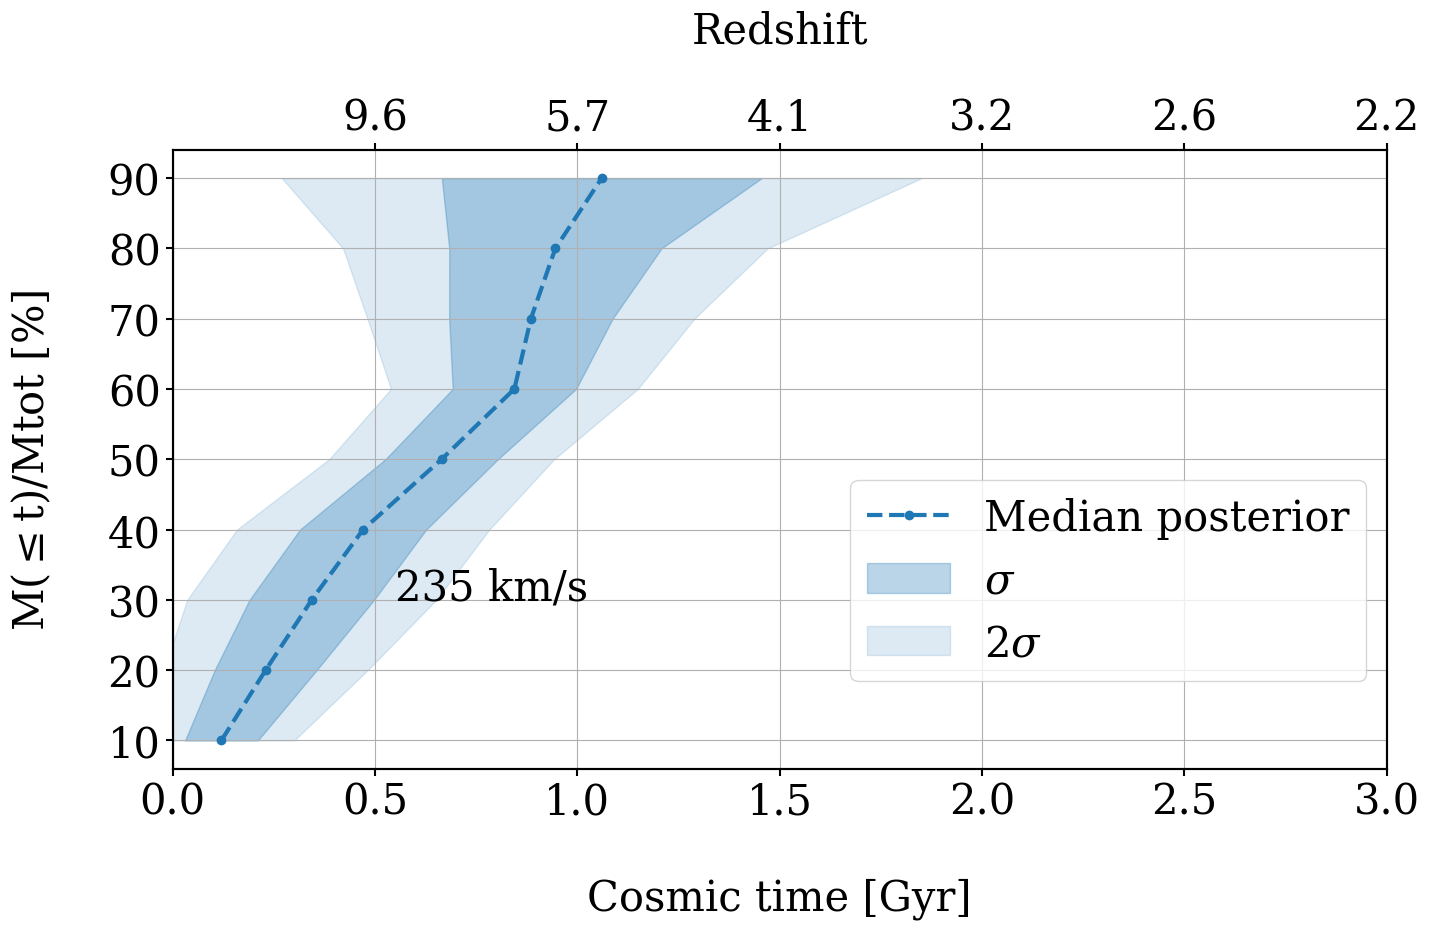

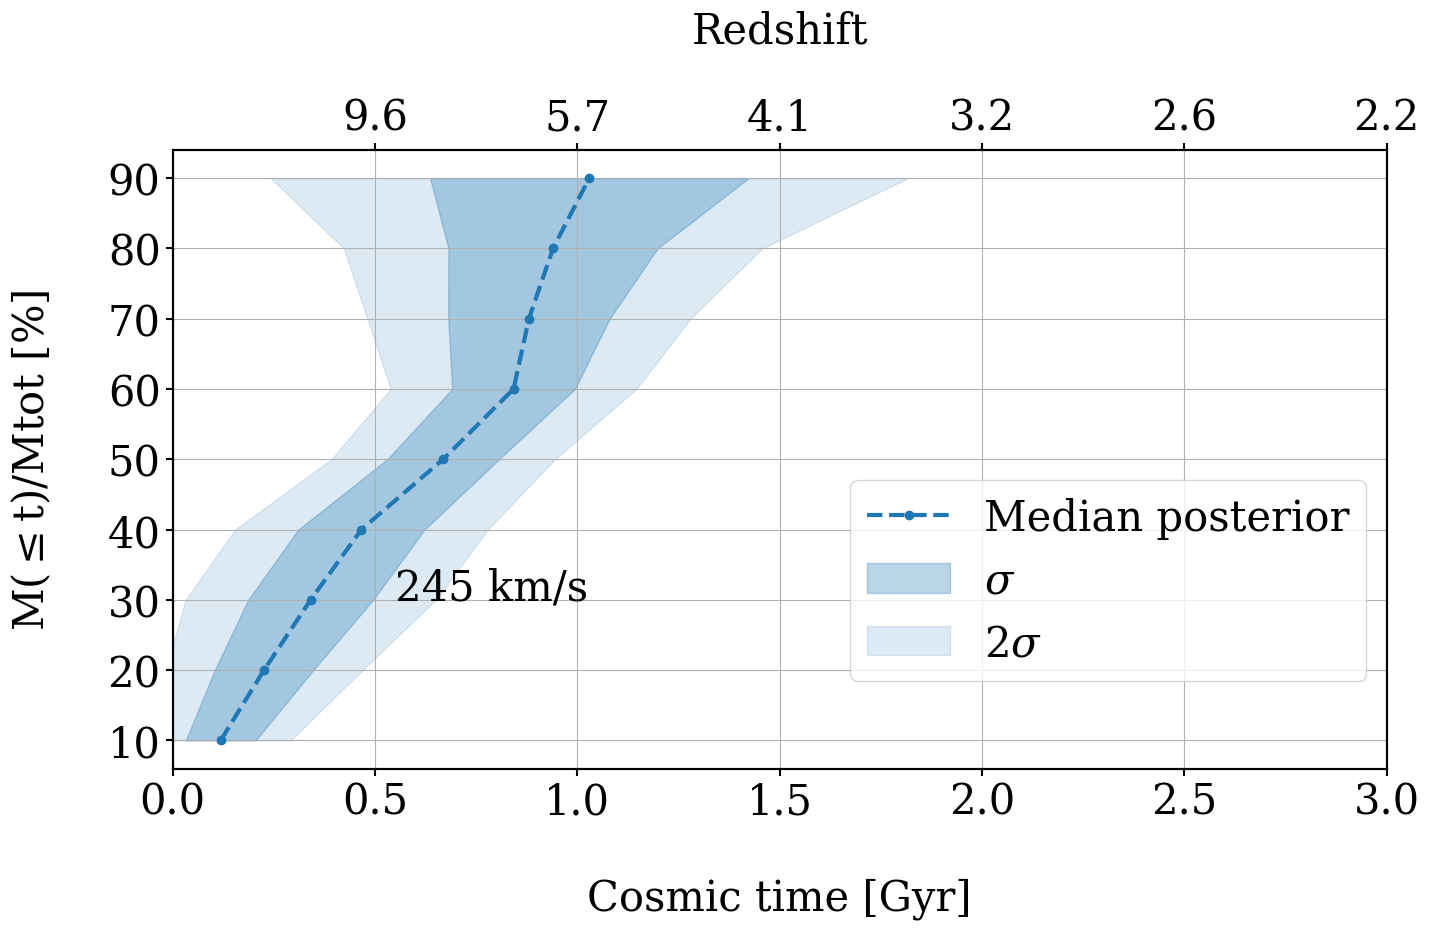

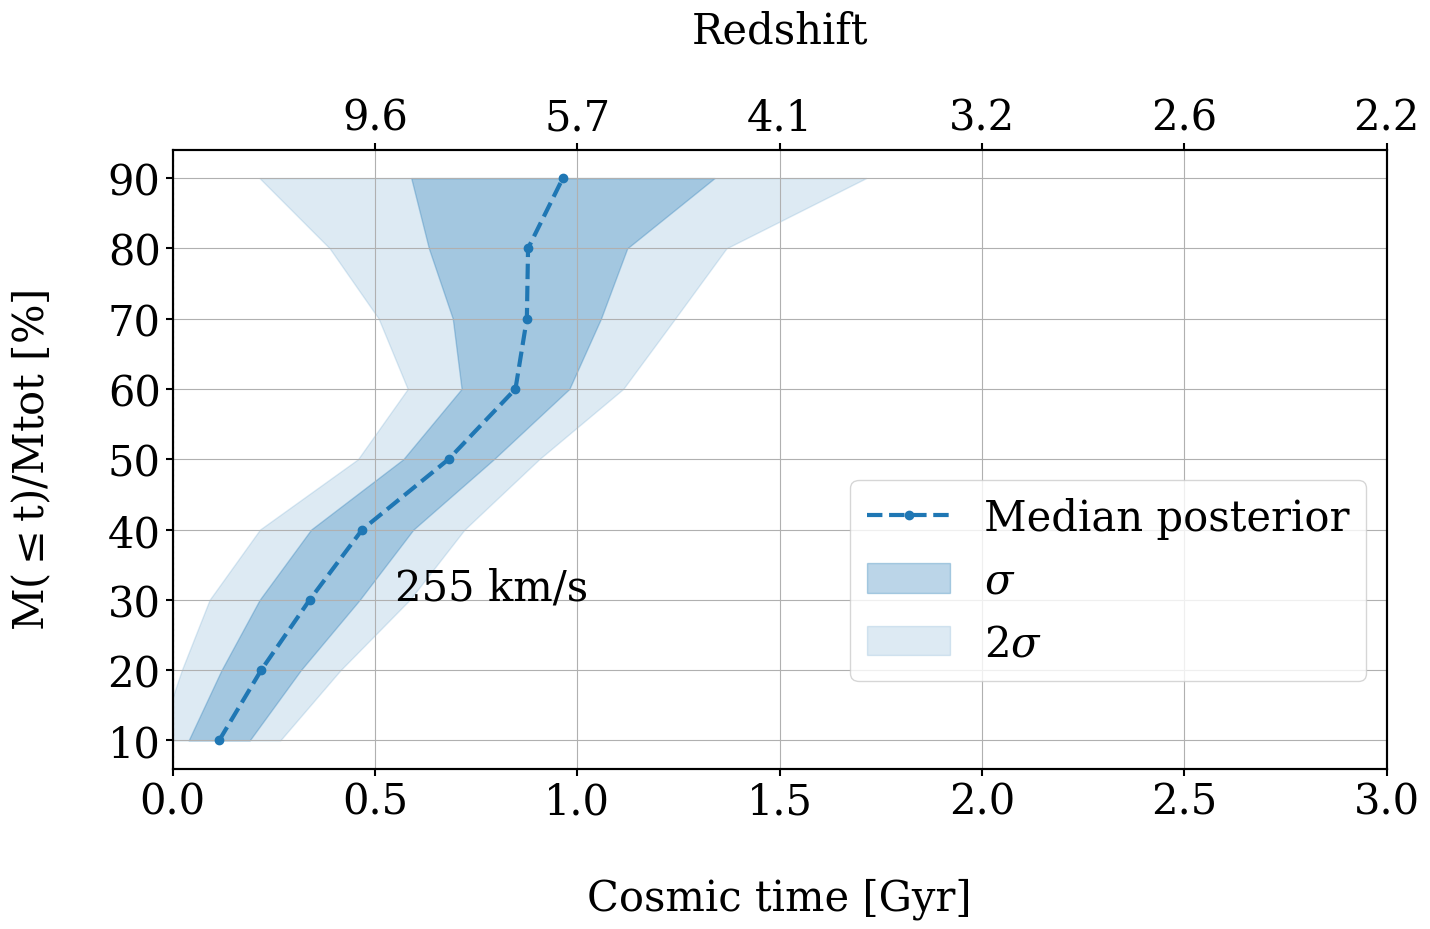

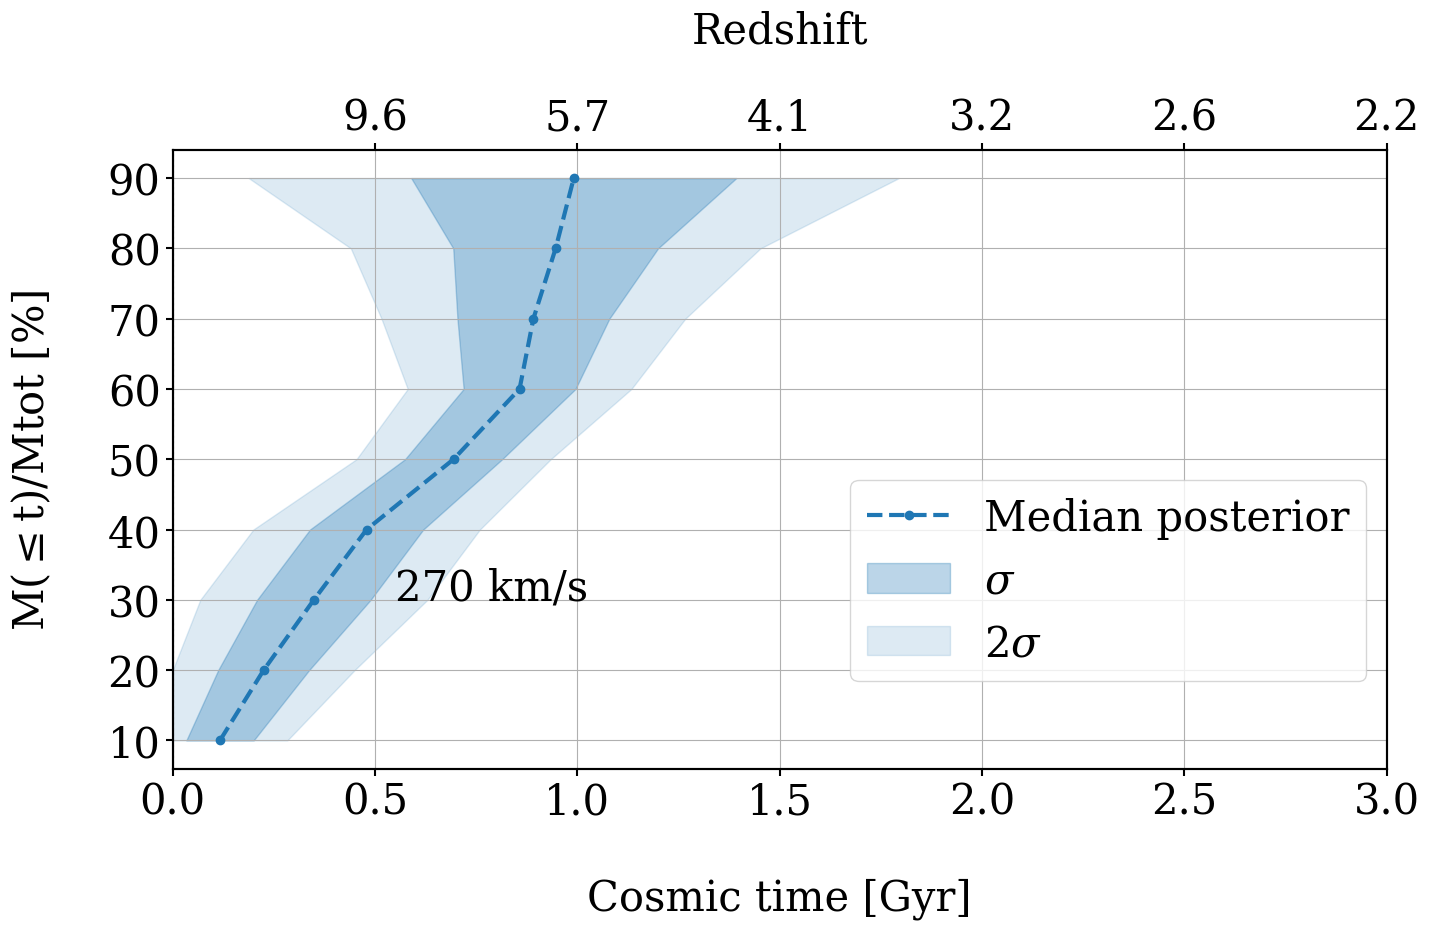

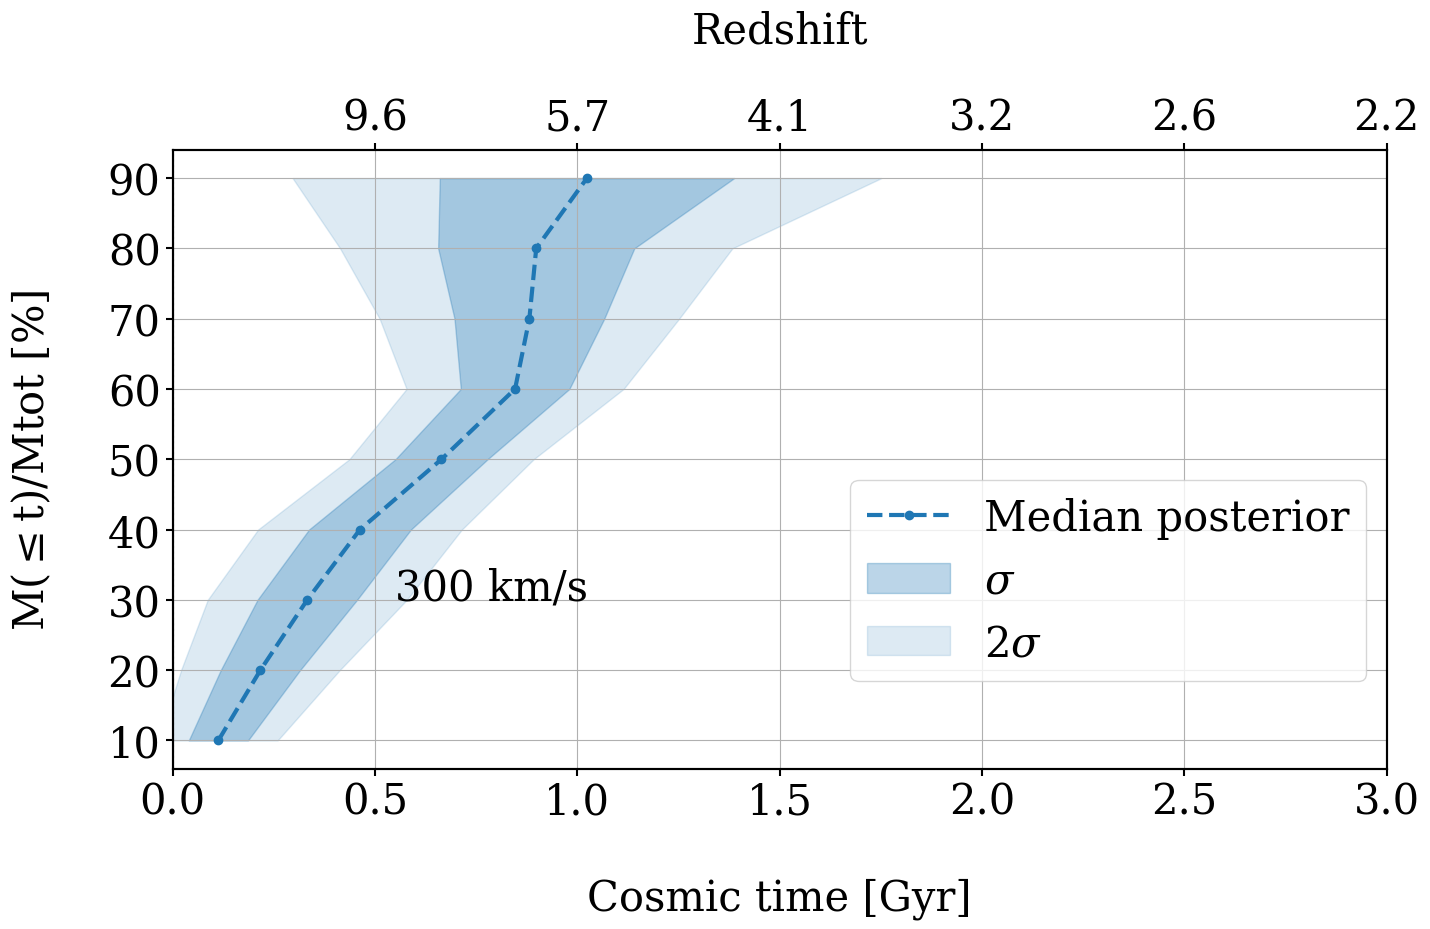

In [10]:
def plot_percentile_distribution(preds_mean=post_median,preds_stds=post_stds,index_list=range(18)):

    """Plot percentile predictions with their uncertainites for observed stacks of ETGs

    Parameters
    ----------
    preds_mean: array, size (len(index_list),10)
        Median of the posteriors predicted for the 10 features

    preds_stds: array, size (len(index_list),10)
        Standard deviations of the posteriors predicted for the 10 features
    
    index_list: list, default size (18)
        Indeces of the observations
    """
    for k,j in enumerate(index_list):
                
            pred_mean=preds_mean[j]
            pred_stds=preds_stds[j]

            fig,ax=plt.subplots()
            ax.plot(pred_mean[:9],np.arange(10,100,10),'o--',color='tab:blue',label='Median posterior',lw=3)
            
           #plt.title('Percentiles galaxy ' +str(int(sigma_gal[j]))+' km/s'+'\n')
            plt.text(0.55,30,str(int(sigma_gal[j]))+' km/s')
            plt.xlabel('\n'+'Cosmic time [Gyr]')
            plt.ylabel('M($\leq$t)/Mtot [%]'+'\n')
            plt.axvline(0,0,1,ls=':',color='grey')

            ax2 = ax.twiny()
        
            xt=np.arange(0,3.5,0.5)
            xl=z(xt[1:])
            ax2.set_xticks(xt[1:],labels=xl)
            ax2.set_xlabel('Redshift'+'\n')

            ax.fill_betweenx(np.arange(10,100,10),pred_mean[:9]+pred_stds[:9],pred_mean[:9]-pred_stds[:9],color='tab:blue',alpha=0.3,label='$\\sigma$')
            
            ax.fill_betweenx(np.arange(10,100,10),pred_mean[:9]+2*pred_stds[:9],pred_mean[:9]-2*pred_stds[:9],color= 'tab:blue',alpha=0.15,label='$2\\sigma$')
            


            ax.legend(bbox_to_anchor=(1, 0.5))

            ax.set_xlim(0,3)

            ax.set_yticks(np.arange(10,100,10))
            ax.grid()
            

            plt.tight_layout()
            #plt.savefig('pred_gal_'+str(int(sigma_gal[j]))+'.jpg')
            plt.show()


plot_percentile_distribution()

Plot showing the 18 predictions for the percentiles of stellar mass of the stacks of ETGs

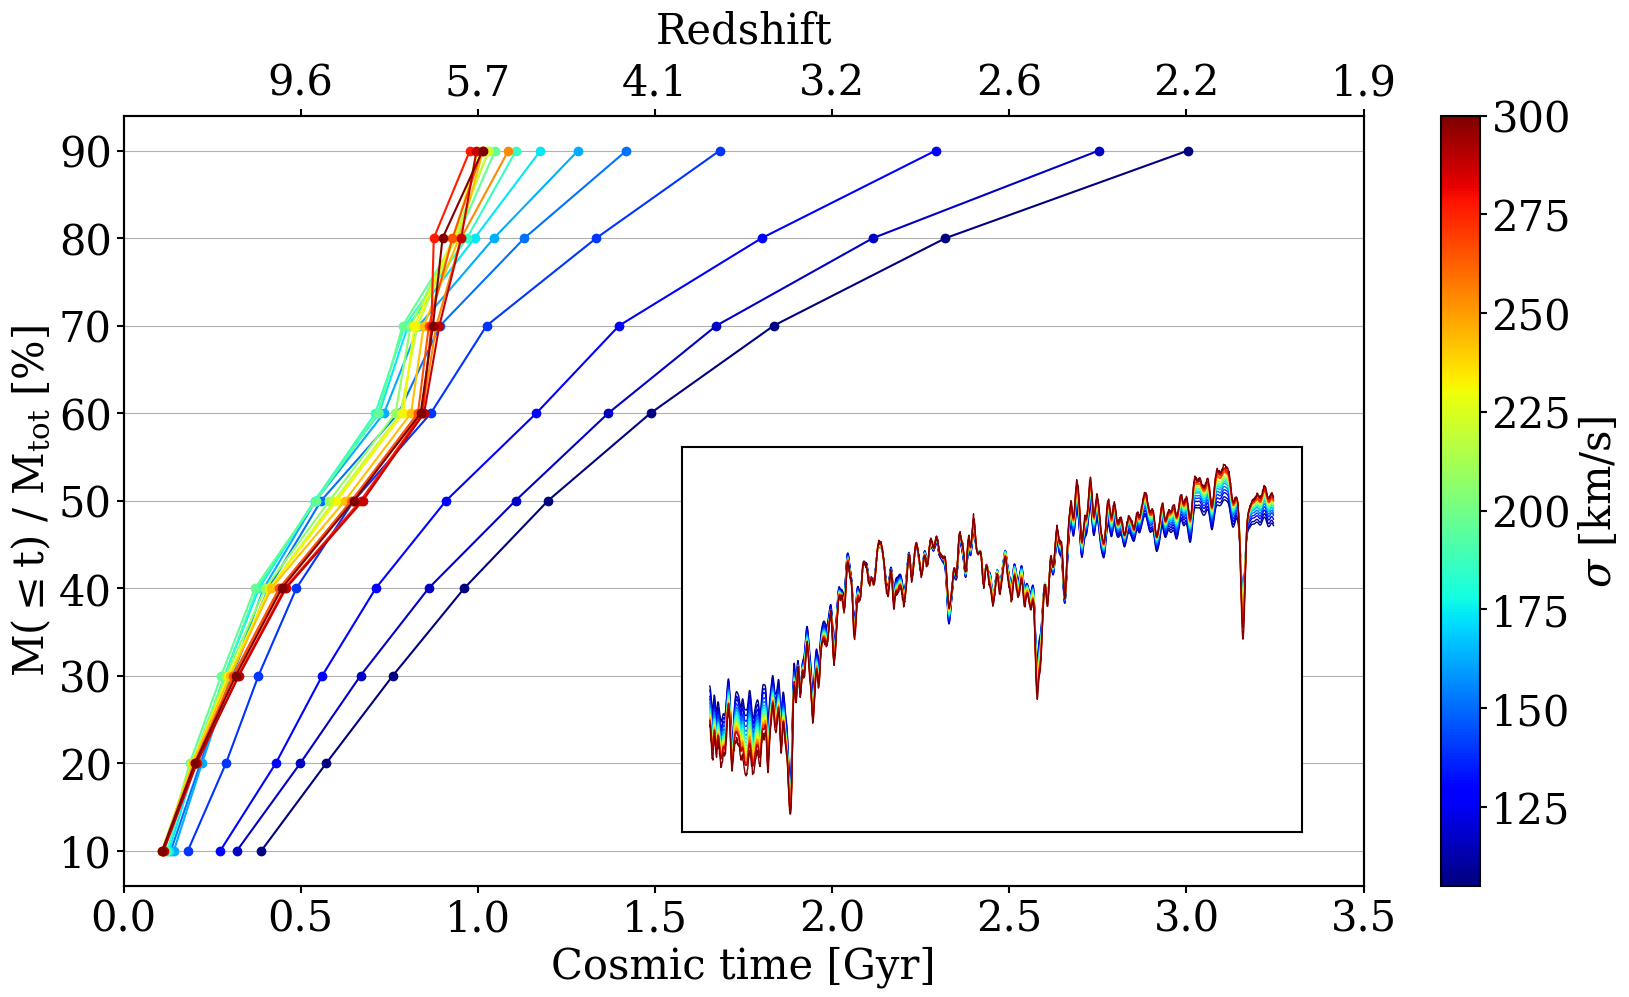

In [27]:

mpl.rcParams["figure.figsize"] = (20,10)

w=np.arange(4023,6001)

colors=plt.cm.jet(np.linspace(0,1,18))
fig,ax=plt.subplots()

for k,j in enumerate(range(18)):
            
    ax.plot(post_median[j][:9],np.arange(10,100,10),'o-',color=colors[k])
    plt.scatter(post_median[j][:9],np.arange(10,100,10),marker='None',c=sigma_gal[k]*np.ones((9,)),cmap='jet')


plt.xlabel('Cosmic time [Gyr]')
plt.ylabel('M($\leq$t) / M$_{\\rm tot}$ [%]')
ax2 = ax.twiny()
xt=np.arange(0,4,0.5)
xl=z(xt[1:])
ax2.set_xticks(xt[1:],labels=xl)
ax2.set_xlabel('Redshift',labelpad=14)
ax.set_xlim(0,3.5)
ax.set_yticks(np.arange(10,100,10))
ax.grid(axis='y')

axin = ax.inset_axes([0.45, 0.07, 0.5, 0.5])
for i in range(18):
    axin.plot(w,seds[i,:],c=colors[i],lw=1)
axin.set_yticks([])
axin.set_xticks([])

plt.colorbar(label='$\\sigma$ [km/s]')
plt.clim(105,300)
plt.savefig('pred_gal_full.pdf')
plt.show()

Create a dataframe with the predictions of our model and transform it into a Latex table

In [88]:
import pandas as pd

files= sorted(os.listdir('/Users/patriglesiasnavarro/Desktop/ULL/Master/Segundo/TFM/programas/intermediate_steps/observations_prior_redshift/obs/'))[2:]
arrs=[]
for f in files:
    arrs.append(str(int(float(f[6:12])))+'-'+str(int(float(f[13:19])))) #just names of files from which we get the ranges of velocity dispersion

label=['P'+str(i)+'\%'+' [Gyr]' for i in np.arange(10,100,10)]
label.append('[M/H]')


data=np.zeros((18,10),dtype=object)

for i in range(18):
    for j in range(10):
        data[i,j]=str(np.around(means[i,j],2))+'$\pm$'+str(np.around(stds[i,j],2))

df = pd.DataFrame(data,columns=[label[i] for i in range(10)], index = [arrs[i] for i in range(18)])

df

,P10\% [Gyr],P20\% [Gyr],P30\% [Gyr],P40\% [Gyr],P50\% [Gyr],P60\% [Gyr],P70\% [Gyr],P80\% [Gyr],P90\% [Gyr],[M/H]
100-110,0.42$\pm$0.22,0.6$\pm$0.26,0.78$\pm$0.3,0.97$\pm$0.33,1.21$\pm$0.34,1.5$\pm$0.37,1.81$\pm$0.42,2.27$\pm$0.45,2.89$\pm$0.63,0.11$\pm$0.24
110-120,0.36$\pm$0.22,0.54$\pm$0.26,0.69$\pm$0.29,0.87$\pm$0.32,1.12$\pm$0.32,1.39$\pm$0.35,1.67$\pm$0.41,2.1$\pm$0.46,2.63$\pm$0.66,0.13$\pm$0.23
120-130,0.32$\pm$0.21,0.47$\pm$0.26,0.6$\pm$0.29,0.75$\pm$0.32,0.95$\pm$0.33,1.19$\pm$0.37,1.41$\pm$0.45,1.79$\pm$0.52,2.21$\pm$0.75,-0.05$\pm$0.32
130-140,0.23$\pm$0.17,0.34$\pm$0.22,0.43$\pm$0.26,0.55$\pm$0.28,0.72$\pm$0.29,0.93$\pm$0.33,1.08$\pm$0.4,1.38$\pm$0.48,1.66$\pm$0.7,-0.12$\pm$0.4
140-150,0.16$\pm$0.13,0.26$\pm$0.18,0.35$\pm$0.21,0.46$\pm$0.24,0.63$\pm$0.24,0.83$\pm$0.26,0.94$\pm$0.32,1.18$\pm$0.39,1.43$\pm$0.57,0.06$\pm$0.38
150-160,0.17$\pm$0.13,0.26$\pm$0.19,0.35$\pm$0.22,0.45$\pm$0.24,0.61$\pm$0.25,0.8$\pm$0.27,0.89$\pm$0.33,1.11$\pm$0.41,1.31$\pm$0.61,-0.05$\pm$0.39
160-170,0.15$\pm$0.12,0.24$\pm$0.17,0.32$\pm$0.2,0.42$\pm$0.22,0.59$\pm$0.21,0.77$\pm$0.23,0.84$\pm$0.28,1.02$\pm$0.35,1.18$\pm$0.54,0.01$\pm$0.4
170-180,0.15$\pm$0.11,0.24$\pm$0.17,0.33$\pm$0.21,0.42$\pm$0.22,0.6$\pm$0.21,0.76$\pm$0.23,0.83$\pm$0.28,0.99$\pm$0.36,1.11$\pm$0.53,-0.05$\pm$0.4
180-190,0.13$\pm$0.1,0.22$\pm$0.16,0.31$\pm$0.19,0.41$\pm$0.21,0.59$\pm$0.2,0.76$\pm$0.21,0.82$\pm$0.25,0.97$\pm$0.32,1.08$\pm$0.5,-0.07$\pm$0.41
190-200,0.13$\pm$0.09,0.23$\pm$0.14,0.33$\pm$0.19,0.44$\pm$0.19,0.62$\pm$0.18,0.8$\pm$0.19,0.84$\pm$0.23,0.96$\pm$0.3,1.04$\pm$0.46,0.01$\pm$0.37


In [89]:
print(df.to_latex(escape=False))

\begin{tabular}{lllllllllll}
\toprule
{} &    P10\% [Gyr] &    P20\% [Gyr] &    P30\% [Gyr] &    P40\% [Gyr] &    P50\% [Gyr] &    P60\% [Gyr] &    P70\% [Gyr] &    P80\% [Gyr] &    P90\% [Gyr] &           [M/H] \\
\midrule
100-110 &  0.42$\pm$0.22 &   0.6$\pm$0.26 &   0.78$\pm$0.3 &  0.97$\pm$0.33 &  1.21$\pm$0.34 &   1.5$\pm$0.37 &  1.81$\pm$0.42 &  2.27$\pm$0.45 &  2.89$\pm$0.63 &   0.11$\pm$0.24 \\
110-120 &  0.36$\pm$0.22 &  0.54$\pm$0.26 &  0.69$\pm$0.29 &  0.87$\pm$0.32 &  1.12$\pm$0.32 &  1.39$\pm$0.35 &  1.67$\pm$0.41 &   2.1$\pm$0.46 &  2.63$\pm$0.66 &   0.13$\pm$0.23 \\
120-130 &  0.32$\pm$0.21 &  0.47$\pm$0.26 &   0.6$\pm$0.29 &  0.75$\pm$0.32 &  0.95$\pm$0.33 &  1.19$\pm$0.37 &  1.41$\pm$0.45 &  1.79$\pm$0.52 &  2.21$\pm$0.75 &  -0.05$\pm$0.32 \\
130-140 &  0.23$\pm$0.17 &  0.34$\pm$0.22 &  0.43$\pm$0.26 &  0.55$\pm$0.28 &  0.72$\pm$0.29 &  0.93$\pm$0.33 &   1.08$\pm$0.4 &  1.38$\pm$0.48 &   1.66$\pm$0.7 &   -0.12$\pm$0.4 \\
140-150 &  0.16$\pm$0.13 &  0.26$\pm$0.18 &  0.3

/var/folders/26/90klcxjd1_x9q0l8mz3tx1g00000gn/T/ipykernel_30688/4079661275.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(escape=False))
